In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/bde73ad6-ce46-489b-8ee0-b162698cc6df.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/c7ce1ac6-36e4-4258-b2e4-1b525dc82ad5.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/9d75e205-3030-44c6-ae

# Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import json
from tqdm.autonotebook import tqdm
import string
import collections
from textblob import TextBlob

import spacy

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import utils
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
#define stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [4]:
def clean_text(txt):
     return re.sub('[^A-Za-z0-9.]+', ' ', str(txt).lower())

In [5]:
#https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

def text_cleaning(text, flg_stemm = False, flg_lemm = True, lst_stopwords = None):
    '''
    Converts all text to lower case, tokenize, remove multiple spaces, stopwords, stemming, lemmatize, 
    then convert all back to string
    
    text: string - name of column containing text
    lst_stopwords: list - list of stopwords to remove
    flg_stemm: bool - whether stemming is to be applied
    flg_lemm: bool - whether lemmitisation is to be applied
    '''
    
    #clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    #tokenize (convert from string to list)
    lst_text = text.split()
    
    #remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    stopwords_list]
                
    #stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    #lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    #back to string from list
    text = " ".join(lst_text)
    return text

In [6]:
MAX_LENGTH = 64
OVERLAP = 20
    
def shorten_sentences(sentences):
    """
    Sentences that have more than MAX_LENGTH words will be split
    into multiple sentences with overlappings.
    """
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences

# OBTAIN

In [7]:
#define paths
os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')
train_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [8]:
#create a function to get the text from the JSON file and append it to the new column in table
def read_json_pub(filename, train_path = train_path, output = 'text'):
    json_path = os.path.join(train_path, (filename + '.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [9]:
#read 
train = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')

#review
train.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


# Create Sentences & Labels

In [10]:
#https://www.kaggle.com/jagdmir/spacy-ner-model

import nltk

DATA = []
label_count = 0

for idx,row in tqdm(train.iterrows()):
    pub = "../input/coleridgeinitiative-show-us-the-data/train/" + row.Id + ".json"            
    f = open(pub)  
    data = json.load(f)      
    
    balanced = False

    sentences = [clean_text(sentence) for sentence in nltk.sent_tokenize(str(data))]
    sentences = shorten_sentences(sentences) # make sentences short
    sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars
    
    for sentence in sentences:          
      
        a = re.search(row.cleaned_label.lower(), sentence)
        b = re.search(row.dataset_label.lower(), sentence)
        c = re.search(row.dataset_title.lower(), sentence)
        cleaned_label = row.cleaned_label.lower()
        dataset_label = row.dataset_label.lower()
        dataset_title = row.dataset_title.lower()
        
        if  a != None:
            DATA.append((sentence, cleaned_label))
            label_count = label_count + 1
            balanced = True
        elif b != None:
            DATA.append((sentence, dataset_label))
            label_count = label_count + 1
            balanced = True
        elif c != None:
            DATA.append((sentence, dataset_title))
            label_count = label_count + 1
            balanced = True  
            
        else:
            pass
                
print("Text with dataset:", label_count)

0it [00:00, ?it/s]

Text with dataset: 64512


In [11]:
#get dataframe
train_df = pd.DataFrame(DATA)
train_df = train_df.rename({0: 'Sentence', 1: 'Label'}, axis = 1)

#review
train_df.tail(10)

,Sentence,Label
64502,the international community came together to b...,rsna international covid open radiology database
64503,then several 3cl pro ligand complexes are used...,cas covid 19 antiviral candidate compounds dat...
64504,mccs was then applied to carry out the virtual...,cas covid 19 antiviral candidate compounds dat...
64505,section title repurposing cas covid 19 antivi...,cas covid 19 antiviral candidate compounds dat...
64506,using this data we applied a variety of machin...,cas covid 19 antiviral candidate compounds dat...
64507,nearly 50 000 substances from the cas covid 19...,cas covid 19 antiviral candidate compounds dat...
64508,the model was then also applied to the cas cov...,cas covid 19 antiviral candidate compounds dat...
64509,using suitable binary classifiers we were able...,cas covid 19 antiviral candidate compounds dat...
64510,after data cleaning and chemical structure sta...,cas covid 19 antiviral candidate compounds dat...
64511,after data cleaning and chemical structure sta...,cas covid 19 antiviral candidate compounds data


In [12]:
print('Sentence:', train_df['Sentence'][555])
print('\n')
print('Label:', train_df['Label'][555])

Sentence: among other things the slosh model is driven by wind fields derived from the storm generation techniques presented above. nstorm surge generation calculations are applied to a specific location s shoreline incorporating the unique bay and river configurations water depths bridges roads and other physical features.


Label: slosh model


In [13]:
print('Sentence:', train_df['Sentence'][50000])
print('\n')
print('Label:', train_df['Label'][50000])

Sentence: berkner s. cuccaro alamin and a. mccormick descriptive summary of 1989 90 beginning postsecondary students five years later washington dc u.s. department of education national center for education statistics 1996 .


Label: beginning postsecondary students


# PREPROCESSING

### Train-Test-Split

In [14]:
X = train_df['Sentence'].to_numpy()
y = train_df['Label'].to_numpy()

#split traing data into training a validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [15]:
#check shape
print('Train sentences:', X_train.shape, '\n', 
      'Test sentences:', X_test.shape, '\n', 
      'Train labels:', y_train.shape, '\n', 
      'Test labels:', y_test.shape)

Train sentences: (51609,) 
 Test sentences: (12903,) 
 Train labels: (51609,) 
 Test labels: (12903,)


### Tokenize

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#limit on the number of features. We use the top 20K features
top_k = 20000

#limit on the length of text sequences. Sequences longer than this will be truncated
max_sequence_length = 500

#get max sequence length
max_length = len(max(X_train, key = len))
if max_length > max_sequence_length:
    max_length = max_sequence_length
    
max_vocab_length = 20000 # max number of words to have in our vocabulary

#method to count the unique words in vocabulary and assign each of those words to indices
tokenizer = Tokenizer(num_words = top_k)

#create vocabulary with training texts
tokenizer.fit_on_texts(list(X_train))

#convert text into integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
         
#fix sequence length to max value. 
#sequences shorter than the length are padded in the beginning and sequences longer are truncated at the beginning
#this turns our lists of integers into a 2D integer tensor of shape (samples, maxlen)
X_train_pad  = pad_sequences(X_train_seq, maxlen = max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen = max_length)

In [17]:
#number of unique words in the training data
size_of_vocabulary = len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

32917


In [18]:
word_index = tokenizer.word_index

### Encode Label

In [19]:
from sklearn import preprocessing

#use the LabelEncoder to convert text labels to integers, 0, 1, 2, etc.
encoder = preprocessing.LabelEncoder()

#since we have two different data set (X_train and X_test), 
#we need to fit it on all of our data otherwise there might be some categories in the test set X_test that were not in the train set X_train 
#and we will get errors
encoder.fit(list(y_train) + list(y_test)) 
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [20]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (51609,)
X_test shape: (12903,)
y_train shape: (51609,)
y_test shape: (12903,)


In [21]:
encoder.classes_

array(['2019 ncov complete genome sequences', '2019 ncov genome sequence',
       '2019 ncov genome sequences', 'adni',
       'advanced national seismic system anss comprehensive catalog comcat ',
       'advanced national seismic system comprehensive catalog',
       'aging integrated database', 'aging integrated database agid ',
       'agricultural resource management survey',
       'agricultural resources management survey',
       'alzheimer s disease neuroimaging initiative adni ',
       'alzheimers disease neuroimaging initiative',
       'anss comprehensive catalog',
       'anss comprehensive earthquake catalog',
       'arms farm financial and crop production practices',
       'baccalaureate and beyond',
       'baccalaureate and beyond longitudinal study',
       'baltimore longitudinal study of aging',
       'baltimore longitudinal study of aging (blsa)',
       'baltimore longitudinal study of aging blsa ',
       'beginning postsecondary student',
       'beginning p

### Binarize Label

In [22]:
num_classes = train_df['Label'].nunique() + 1
num_classes

133

In [23]:
from keras import utils

#binarize the labels for the neural net
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [24]:
print('X_train shape:', X_train_pad.shape)
print('X_test shape:', X_test_pad.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (51609, 500)
X_test shape: (12903, 500)
y_train shape: (51609, 133)
y_test shape: (12903, 133)


### Load Pretrained Word Vector

In [25]:
#load the whole embedding into memory
embeddings_index = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs
    except ValueError: #catch the exception where there are strings in the GloVe text file, can be avoided if use glove.42B.300d.txt
        pass
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Found 2195885 word vectors.


In [26]:
#create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/32916 [00:00<?, ?it/s]

# MODELING

In [27]:
#hyperparameters
filters = 4
kernel_size = 3
dropout_rate = 0.5
pool_size = 3

In [28]:
#simple bidirectional LSTM with GloVe embeddings and Dense layers
sepcnn_model = Sequential()

#embedding layer
sepcnn_model.add(Embedding(size_of_vocabulary, 
                           300,
                           weights = [embedding_matrix], #load GloVe
                           input_length = X_train_pad.shape[0],
                           trainable = False)) #keep frozen

sepcnn_model.add(Dropout(rate = dropout_rate))
sepcnn_model.add(SeparableConv1D(filters = filters,
                                  kernel_size = kernel_size,
                                  activation = 'relu'))
sepcnn_model.add(SeparableConv1D(filters = filters,
                                  kernel_size = kernel_size,
                                  activation = 'relu'))
    
sepcnn_model.add(MaxPooling1D(pool_size = pool_size))
sepcnn_model.add(SeparableConv1D(filters = filters * 2,
                              kernel_size = kernel_size,
                              activation = 'relu'))

sepcnn_model.add(SeparableConv1D(filters = filters * 2,
                              kernel_size = kernel_size,
                              activation = 'relu'))
                 
sepcnn_model.add(GlobalAveragePooling1D())

sepcnn_model.add(Dropout(rate = dropout_rate))
                          
#output layer
sepcnn_model.add(Dense(num_classes, activation = 'softmax')) 

In [29]:
#summary
sepcnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51609, 300)        9875100   
_________________________________________________________________
dropout (Dropout)            (None, 51609, 300)        0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 51607, 4)          2104      
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 51605, 4)          32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 17201, 4)          0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 17199, 8)          52        
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 17197, 8)          9

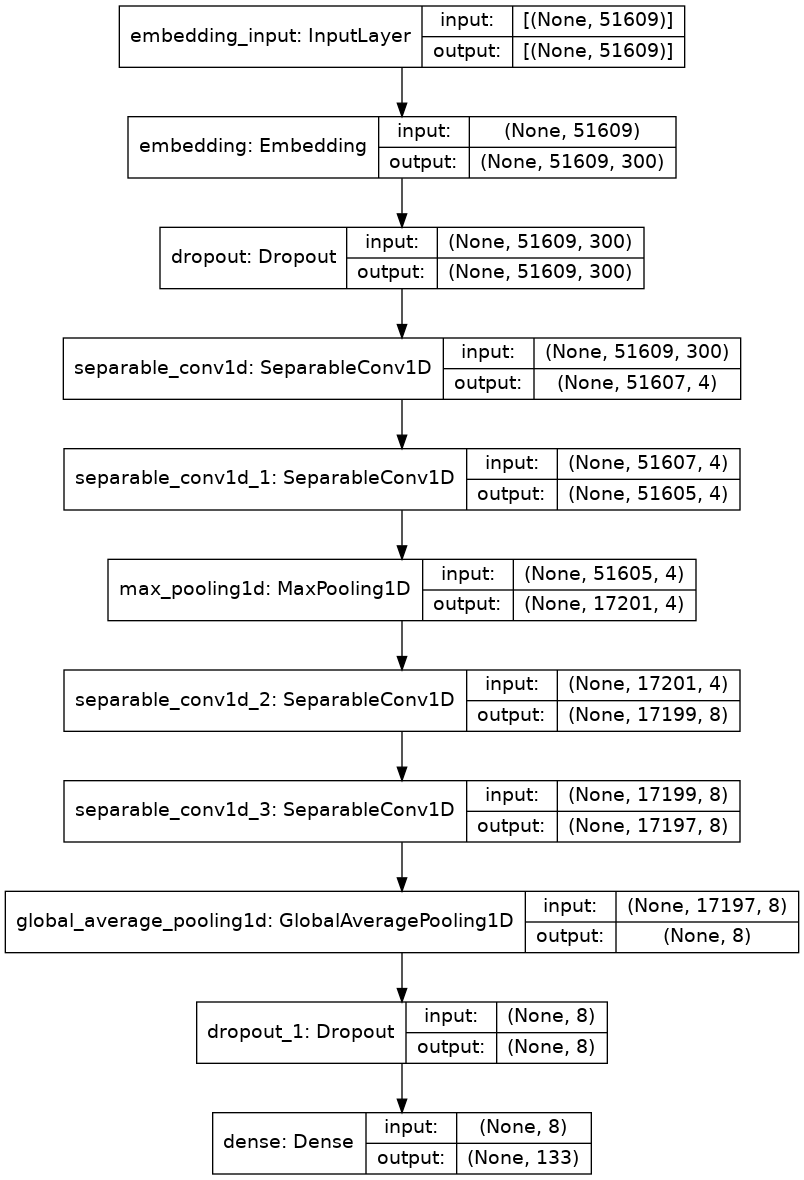

In [30]:
#plot
plot_model(sepcnn_model, to_file = 'sepcnn_model_plot.png', show_shapes = True, show_layer_names = True)

In [31]:
#compile
sepcnn_model.compile(optimizer = keras.optimizers.Adam(0.0001), #low learning rate is good, but the model will take more iterations to converge
                    loss = 'categorical_crossentropy',
                    metrics = ['acc'])

In [32]:
#from sklearn.utils import class_weight

#correct class imbalance
#class_weights = list(class_weight.compute_class_weight('balanced',
#                                                       np.unique(train_df['Label']),
#                                                       train_df['Label']))

#weights = {}
#for index, weight in enumerate(class_weights) : weights[index] = weight

In [33]:
print('X_train shape:', X_train_pad.shape)
print('X_test shape:', X_test_pad.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (51609, 500)
X_test shape: (12903, 500)
y_train shape: (51609, 133)
y_test shape: (12903, 133)


In [34]:
#add callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
                 ModelCheckpoint(filepath = 'sepcnn_model.h5', monitor = 'val_loss', save_best_only = True)]

In [35]:
start = datetime.datetime.now()
batch_size = 256

#fit
sepcnn_history = sepcnn_model.fit(np.array(X_train_pad), np.array(y_train),
                                  #class_weight = weights,
                                  batch_size = batch_size,
                                  epochs = 20,
                                  validation_data = (np.array(X_test_pad), np.array(y_test)),
                                  steps_per_epoch = X_train_pad.shape[0] // 256,
                                  validation_steps = X_test_pad.shape[0] // 256,
                                  callbacks = early_stopping)

Epoch 1/20
201/201 [==============================] - 130s 642ms/step - loss: 4.8824 - acc: 0.1659 - val_loss: 4.8524 - val_acc: 0.0285
Epoch 2/20
201/201 [==============================] - 128s 636ms/step - loss: 4.8357 - acc: 0.0678 - val_loss: 4.7613 - val_acc: 0.0385
Epoch 3/20
201/201 [==============================] - 127s 633ms/step - loss: 4.7141 - acc: 0.0374 - val_loss: 4.4867 - val_acc: 0.0385
Epoch 4/20
201/201 [==============================] - 128s 636ms/step - loss: 4.3681 - acc: 0.0359 - val_loss: 3.8688 - val_acc: 0.0385
Epoch 5/20
201/201 [==============================] - 142s 706ms/step - loss: 3.7776 - acc: 0.0514 - val_loss: 3.1409 - val_acc: 0.4797
Epoch 6/20
201/201 [==============================] - 132s 658ms/step - loss: 3.2143 - acc: 0.3271 - val_loss: 2.7000 - val_acc: 0.4797
Epoch 7/20
201/201 [==============================] - 132s 656ms/step - loss: 2.9677 - acc: 0.4316 - val_loss: 2.6024 - val_acc: 0.4797
Epoch 8/20
201/201 [============================

In [36]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:45:04.621516


In [37]:
#save model
sepcnn_model.save('sepcnn_model.h5')

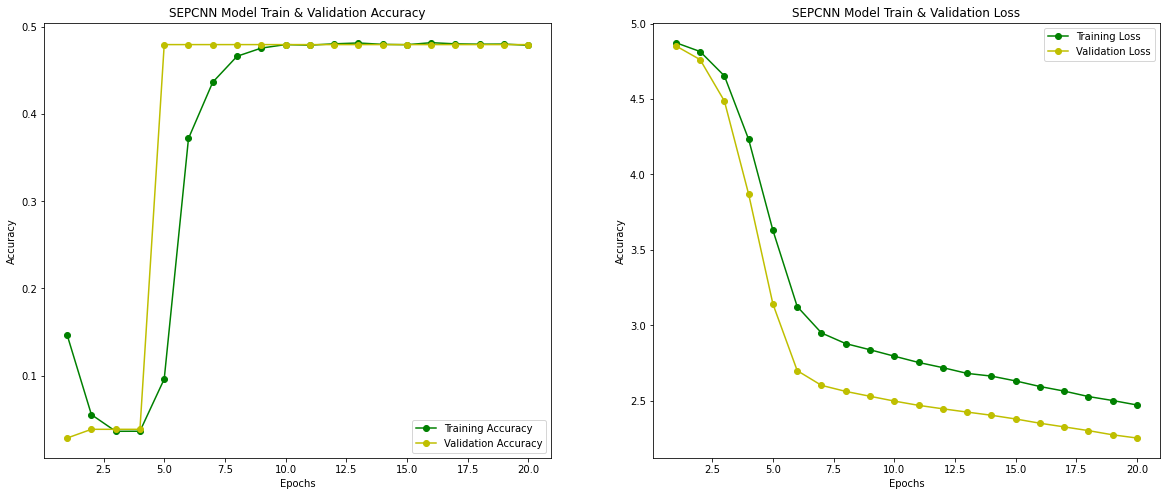

In [38]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

sepcnn_train_acc = sepcnn_history.history['acc']
sepcnn_train_loss = sepcnn_history.history['loss']
sepcnn_val_acc = sepcnn_history.history['val_acc']
sepcnn_val_loss = sepcnn_history.history['val_loss']

epochs = range(1, len(sepcnn_train_acc) + 1)

ax[0].plot(epochs , sepcnn_train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , sepcnn_val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('SEPCNN Model Train & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, sepcnn_train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs, sepcnn_val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('SEPCNN Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()

In [39]:
#save
plt.savefig('sepcnn_acc_loss.png')

<Figure size 432x288 with 0 Axes>

In [40]:
print('Train loss & accuracy:', sepcnn_model.evaluate(X_train_pad, y_train))
print('\n')
print('Test loss & accuracy:', sepcnn_model.evaluate(X_test_pad, y_test))

1613/1613 [==============================] - 24s 15ms/step - loss: 2.2501 - acc: 0.4805
Train loss & accuracy: [2.2500786781311035, 0.4804975986480713]


404/404 [==============================] - 6s 15ms/step - loss: 2.2534 - acc: 0.4797
Test loss & accuracy: [2.253352165222168, 0.4796558916568756]


In [41]:
#make prediction
sepcnn_yhat_test = sepcnn_model.predict(X_test_pad)

#to evaluate accuracy we need a vector of labels
sepcnn_yhat_test = np.argmax(sepcnn_yhat_test, axis = 1)
sepcnn_y_test = np.argmax(y_test, axis = 1)

#get classification report
print('Model: SEPCNN', '\n', classification_report(sepcnn_y_test, sepcnn_yhat_test))

Model: SEPCNN 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         2
           3       0.48      1.00      0.65      6189
           4       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00       220
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00       726
          11       0.00      0.00      0.00        16
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00       149
          16       0.00      0.00      0.00        60
          17       0.00      0.00      0.00       333
          19       0.00      0.00      0.00       106
          2

In [42]:
preds = encoder.inverse_transform([np.argmax(sepcnn_yhat_test)]) 
preds

array(['2019 ncov complete genome sequences'], dtype='<U128')

In [43]:
#summary table
summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [],
                              'Precision': [], 'Recall': [], 'F1': []})

In [44]:
#update summary table
summary_table.loc[0] = ['DL SEPCNN',
                        round(accuracy_score(sepcnn_y_test, sepcnn_yhat_test), 2),
                        round(precision_score(sepcnn_y_test, sepcnn_yhat_test, average = 'macro'), 2), 
                        round(recall_score(sepcnn_y_test, sepcnn_yhat_test, average = 'macro'), 2), 
                        round(f1_score(sepcnn_y_test, sepcnn_yhat_test, average = 'macro'), 2)]
summary_table.head()

,Model,Accuracy,Precision,Recall,F1
0,DL SEPCNN,0.48,0.0,0.01,0.01


In [45]:
summary_table.to_csv('sepcnn_summary_table.csv')

# PREDICTION

In [46]:
#get text
tqdm.pandas()
train['text'] = train['Id'].progress_apply(read_json_pub)

#clean text
train['text'] = train['text'].progress_apply(clean_text)

  0%|          | 0/19661 [00:00<?, ?it/s]

  0%|          | 0/19661 [00:00<?, ?it/s]

In [47]:
from functools import partial

#read data
sample_submission = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')

#apply the function to submission data
tqdm.pandas()
sample_submission['text'] = sample_submission['Id'].progress_apply(partial(read_json_pub, train_path = test_path))

#review
sample_submission.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


In [48]:
temp_1 = [x.lower() for x in train['dataset_label'].unique()]
temp_2 = [x.lower() for x in train['dataset_title'].unique()]
temp_3 = [x.lower() for x in train['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)

In [49]:
literal_matching = True
sepcnn_prediction = True

id_list = []
labels_list = []

for index, row in tqdm(sample_submission.iterrows()):

    sample_text = row['text']

    row_id = row['Id']
    
    #check if the sample text is equal to one of the train samples and if so, use those labels
    temp_df = train[train['text'] == clean_text(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    
    #literal_matching for known label in sample text
    if literal_matching:
        for known_label in existing_labels:
            if known_label in sample_text.lower():    
                cleaned_labels.append(clean_text(known_label))
            
        print('cleaned label:', set(cleaned_labels))   
    
    #lstm_prediction 
    if sepcnn_prediction:
        
        #extract sentences
        sentences = [clean_text(sentence) for sentence in nltk.sent_tokenize(str(sample_text))]
        sentences = shorten_sentences(sentences) # make sentences short
        sentences = [sentence for sentence in sentences if len(sentence) > 10] # only accept sentences with length > 10 chars        
        
        tokenizer.fit_on_texts(list(sentence))
        sentence_seq = tokenizer.texts_to_sequences([sentence])
        sentence_pad  = pad_sequences(sentence_seq, maxlen = max_length)
            
        #predict
        sepcnn_labels = sepcnn_model.predict(sentence_pad)
    
        #get label
        sepcnn_labels = encoder.inverse_transform([np.argmax(sepcnn_labels)])
            
        print('sepcnn label:', set(sepcnn_labels))
        sepcnn_labels = set(sepcnn_labels)
        
    cleaned_labels += sepcnn_labels
    print('updated cleaned label:', set(cleaned_labels))
        
    cleaned_labels = set(cleaned_labels)
    cleaned_labels = [clean_text(x) for x in cleaned_labels]    
    labels_list.append('|'.join(cleaned_labels))
    print('label list:', labels_list)   
    id_list.append(row_id)
    print('\n')

0it [00:00, ?it/s]

cleaned label: {'adni', 'alzheimer s disease neuroimaging initiative adni '}
sepcnn label: {'adni'}
updated cleaned label: {'adni', 'alzheimer s disease neuroimaging initiative adni '}
label list: ['adni|alzheimer s disease neuroimaging initiative adni ']


cleaned label: {'nces common core of data', 'common core of data', 'trends in international mathematics and science study'}
sepcnn label: {'adni'}
updated cleaned label: {'nces common core of data', 'common core of data', 'trends in international mathematics and science study', 'adni'}
label list: ['adni|alzheimer s disease neuroimaging initiative adni ', 'nces common core of data|common core of data|trends in international mathematics and science study|adni']


cleaned label: {'slosh model', 'noaa storm surge inundation', 'sea lake and overland surges from hurricanes'}
sepcnn label: {'adni'}
updated cleaned label: {'slosh model', 'noaa storm surge inundation', 'adni', 'sea lake and overland surges from hurricanes'}
label list: ['ad

In [50]:
#get dataframe
sample_submission['PredictionString'] = labels_list
sample_submission.drop(columns = 'text', axis = 1, inplace = True)
sample_submission

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
1,2f392438-e215-4169-bebf-21ac4ff253e1,nces common core of data|common core of data|t...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,slosh model|noaa storm surge inundation|adni|s...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,adni|rural urban continuum codes


In [51]:
print(sample_submission['PredictionString'][0])
print('\n')
print(sample_submission['PredictionString'][1])
print('\n')
print(sample_submission['PredictionString'][2])
print('\n')
print(sample_submission['PredictionString'][3])

adni|alzheimer s disease neuroimaging initiative adni 


nces common core of data|common core of data|trends in international mathematics and science study|adni


slosh model|noaa storm surge inundation|adni|sea lake and overland surges from hurricanes


adni|rural urban continuum codes


In [52]:
#save
sample_submission.to_csv('submission.csv', index = False)

#check
submission = pd.read_csv('submission.csv')
submission

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
1,2f392438-e215-4169-bebf-21ac4ff253e1,nces common core of data|common core of data|t...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,slosh model|noaa storm surge inundation|adni|s...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,adni|rural urban continuum codes
